In [1]:
from keras import Model
from keras.applications import VGG16
from keras.callbacks import ModelCheckpoint, Callback
from keras.layers import Input, Dense, LSTM, Embedding, GRU, Flatten
from keras.optimizers import RMSprop
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from PIL import Image

import coco_parse
import numpy as np
import tensorflow as tf
import text_processing

D:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
path_checkpoint = './decoders/VGG16_GRU.hdf5'

In [3]:
train_vocab = text_processing.Vocabulary()
train_vocab.load_vocabulary()

In [4]:
initial_state_size = 512
embedding_out_size = 512

encoder_input = Input(shape=(4096,), name='encoder_input')
encoder_reduction = Dense(initial_state_size, activation='tanh', name='encoder_reduction')

decoder_input = Input(shape=(None,), name='decoder_input')
embedding = Embedding(input_dim=train_vocab.number_of_words, output_dim=embedding_out_size, name='embedding')

gru1 = GRU(initial_state_size, name='GRU1', return_sequences=True)
gru2 = GRU(initial_state_size, name='GRU2', return_sequences=True)
gru3 = GRU(initial_state_size, name='GRU3', return_sequences=True)

flatten = Flatten()

decoder_dense = Dense(train_vocab.number_of_words, activation='softmax', name='decoder_output')

In [5]:
def connect_transfer_values(transfer_values):
    
    initial_state = encoder_reduction(transfer_values)

    X = decoder_input
    
    X = embedding(X)
    
    X = gru1(X, initial_state=initial_state)
    X = gru2(X, initial_state=initial_state)
    X = gru3(X, initial_state=initial_state)

    decoder_output = decoder_dense(X)
    
    return decoder_output

In [6]:
transfer_values = np.load('./cnn_features/vgg16_train.npy')

In [7]:
optimizer = RMSprop(lr=1e-3)

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
decoder_output = connect_transfer_values(transfer_values=encoder_input)

In [9]:
decoder_model = Model(inputs=[encoder_input, decoder_input], outputs=[decoder_output])

In [10]:
decoder_model.compile(optimizer=optimizer,
                      loss='categorical_crossentropy')

In [11]:
decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
encoder_input (InputLayer)      (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 512)    13748224    decoder_input[0][0]              
__________________________________________________________________________________________________
encoder_reduction (Dense)       (None, 512)          2097664     encoder_input[0][0]              
__________________________________________________________________________________________________
GRU1 (GRU)

### Checkpoints

During the training process, it is a good idea to save the weights periodically.

In [12]:
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.6
set_session(tf.Session(config=config))

In [13]:
try:
    decoder_model.load_weights(path_checkpoint)
except:
    print("Error while loading weights")

In [14]:
def image_preprocessing(image_path, new_size):
    """
    Reads the image and applies preprocessing including:
    - resizing to the new_size
    - rescaling pixel values at [0, 1]
    - transforming grayscale images to RGB format
    
    Parameters:
    -----------
    image_path : str
        full path to the image
    new_size: tuple
        size of the output image
    -----------
    """
    image = Image.open(image_path)
    image = np.array(image.resize(new_size, Image.LANCZOS))
    image = np.divide(image, 255)
    if len(image.shape) != 3:
        image = np.repeat(image[:, :, np.newaxis], 3, axis=2)
    return image

In [15]:
def generate_caption(image_path, model_image_size, decoder_model, transfer_model, vocabulary , max_caption_len=30):
    """
    Generates a caption for a given image
    
    """
    
    img = image_preprocessing(image_path, model_image_size)
    
    image_batch = np.expand_dims(img, axis=0)
    
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    keras.backend.set_session(sess)
    
    input_transfer_values = transfer_model.predict(image_batch)
    
    decoder_input = np.zeros(shape=(1, max_caption_len), dtype=np.int)
    
    caption = []
    
    token = vocabulary.get_id_by_word('<sos>')
    
    while len(caption) < max_caption_len and token != vocabulary.get_id_by_word('<eos>'):
        
        decoder_input[0, len(caption)] = token
        
        input_data = {
            'encoder_input': input_transfer_values,
            'decoder_input': decoder_input
        }
    
        decoder_output = decoder_model.predict(input_data)
        token = np.argmax(decoder_output[0, len(caption), :], axis=0)

        caption.append(vocabulary.get_word_by_id(token))
    
    plt.imshow(img)
    plt.show()
    
    print(" ".join(caption[:-1]))
    return decoder_output

### Encoder model for predictions

In [16]:
VGG_model = VGG16(include_top=True, weights='imagenet')
transfer_layer = VGG_model.get_layer('fc2')
VGG_transfer_model = Model(inputs=VGG_model.input, outputs=transfer_layer.output)
input_layer = VGG_model.get_layer('input_1')
VGG_image_size = input_layer.input_shape[1:3]

In [17]:
VGG_transfer_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

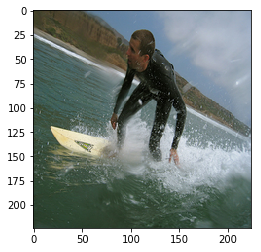

a man in a red shirt and a hat


In [26]:
import tensorflow as tf
from tensorflow import keras


decoder_output = generate_caption('D:/coco/images/val2017\\val2017\\000000051314.jpg', VGG_image_size, decoder_model, VGG_transfer_model, train_vocab)